# **Dessert Flavor Combinations**
The goal here is predict what flavor combinations make for a good dessert. E.g. history tells us apple, cinammon, and nutmeg pair well because a large number of recipies use these flavors and these recipies are generally well rated. Here, I attempt to do this with a data set scrapped from epicurious.com. Basically, the features are a list of flavors present in the recipie and the target is the rating (0 to 4 stars)

In [79]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk as nltk
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline, make_union
from sklearn.decomposition import SparsePCA, TruncatedSVD, PCA, DictionaryLearning, NMF
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1) Load data

In [3]:
dataset = pd.read_csv('recipes.csv')
dataset

,recipe_name,flavors,rating,success
0,Big Apple Crumble Cupcakes,cinnamon cinnamon apple cinnamon vanilla,0.0,0.00
1,Bacon-Latticed Apple Pie,apple lemon cinnamon nutmeg,0.0,0.00
2,Lemon and Fig Cupcakes,vanilla lemon lemon fig vanilla,0.0,0.00
3,Toasted Coconut Chia Pudding,almond coconut,0.0,0.00
4,Coconut-Strawberry Ice Cream Pie,coconut graham coconut coconut strawberry stra...,4.0,0.10
5,Apple Walnut Bundt Cake,walnut cinnamon apple vanilla caramel,4.0,0.10
6,Caramel Sauce and Glaze,vanilla,0.0,0.00
7,Sweet Potato Sonker with Milk Dip,apple vanilla,0.0,0.00
8,Peach Lassi Sorbet with Crushed Blackberries,peach vodka honey blackberry lemon,0.0,0.00
9,Plum-Cardamom Crumble with Pistachios,plum lemon lemon cinnamon pistachio,0.0,0.00


## 2) Clean Data

In [4]:
#Remove entires that dont have strings for the flavors
dataset = dataset[dataset['flavors'].apply(lambda x: isinstance(x, str))]

#tokenize the flavor string 
temp = dataset['flavors'].apply(lambda x: np.unique(nltk.word_tokenize(x)))

#Calc number of flavors
dataset.loc[:,'num_flavors'] = temp.apply(lambda x: x.shape[0])

#Remove entries with only 1 flavor
dataset = dataset[dataset['num_flavors'] > 1]

#convert rating to float
dataset.loc[:,'rating'] = dataset['rating'].apply(lambda x: float(x))

dataset.loc[:,'flavors_clean'] = temp.apply(lambda x: "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in x]).strip())

#So, one thing I have yet to do is account for recipes that have no reviews...
#I need to re-scrape the data set to get that info, for now lets just remove
#recipies with a rating of 0
dataset = dataset[dataset['rating'] != 0]
dataset

/home/lgriffin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/lgriffin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,recipe_name,flavors,rating,success,num_flavors,flavors_clean
4,Coconut-Strawberry Ice Cream Pie,coconut graham coconut coconut strawberry stra...,4.0,0.10,4,coconut graham lemon strawberry
5,Apple Walnut Bundt Cake,walnut cinnamon apple vanilla caramel,4.0,0.10,5,apple caramel cinnamon vanilla walnut
13,Date Ice Cream (Buza ‘Ala-Tamr),rose cardamom date pistachio,2.0,0.00,4,cardamom date pistachio rose
16,Cinnamon-Oat Peach Crisp,peach oat cinnamon vanilla,4.0,0.10,4,cinnamon oat peach vanilla
20,Big-Batch Strawberry Compote,strawberry lemon lemon,4.0,0.10,2,lemon strawberry
21,"Southern ""One-Cup"" Peach Cobbler",peach lemon lemon vanilla vanilla,3.5,0.91,3,lemon peach vanilla
22,Rhubarb Custard Cake,rum lemon rhubarb,3.5,0.83,3,lemon rhubarb rum
26,Double-Decker Peanut Butter Brownies,vanilla almond vanilla coconut cocoa pretzel,3.0,0.63,5,almond cocoa coconut pretzel vanilla
27,Chocolate Peanut Butter-Covered Cheez-It S'mores,chocolate peanut cocoa marshmallow,4.0,0.10,4,chocolate cocoa marshmallow peanut
28,Banana Coconut Muffins,banana vanilla coconut,3.5,0.94,3,banana coconut vanilla


## 3) Preprocess

In [48]:
#Get features and targets
features = dataset['flavors_clean'].values
targets = dataset['rating'].values

#First lets try the hold-out method for validation
train, test, y_train, y_test = train_test_split(features, targets, test_size=0.40, random_state=0)
test, valid, y_test, y_valid = train_test_split(test, y_test, test_size=0.40, random_state=0)

print(train.shape)
print(test.shape)
print(valid.shape)

(3474,)
(1390,)
(927,)


In [9]:
#Set up a pipeline:
#   1) Use TF-IDF to generate features
#   2) maybe other things later????
vectorizer = make_pipeline(
    TfidfVectorizer(sublinear_tf=True)
)

x_train = vectorizer.fit_transform(train)
x_test = vectorizer.transform(test)
x_valid = vectorizer.transform(valid)

(3474,)

## 4) Check out our data

<IPython.core.display.Javascript object>


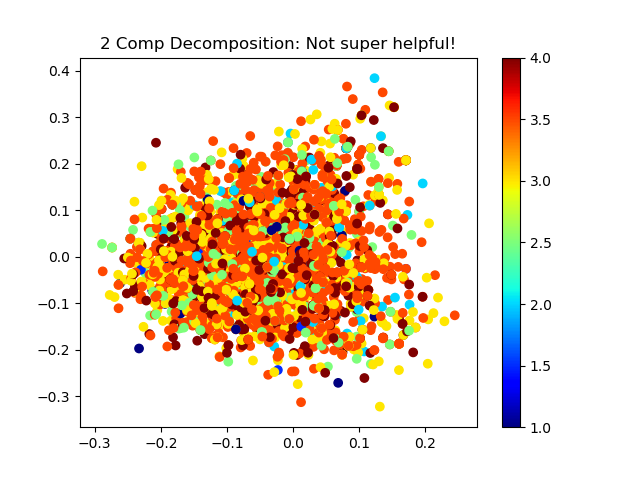

<IPython.core.display.Javascript object>


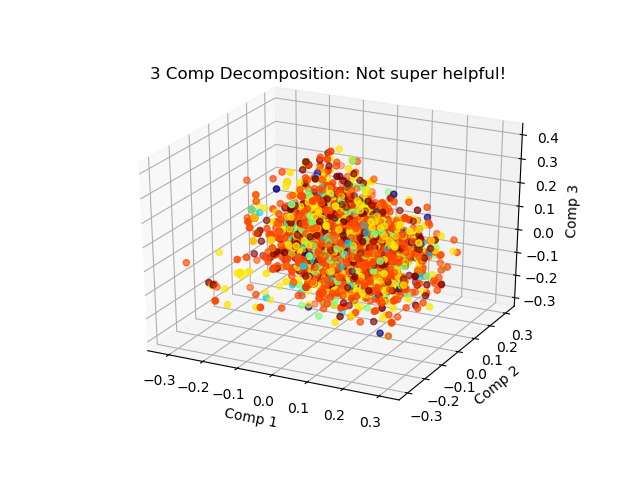

In [62]:
#Start with dimensional reduction to view it in 2D
fig = plt.figure()
dim_red = DictionaryLearning(2)
reduced_data = dim_red.fit_transform(x_train.toarray())
plt.scatter(reduced_data[:,0],reduced_data[:,1],c=y_train,cmap='jet')
plt.colorbar()
plt.title('2 Comp Decomposition: Not super helpful!')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dim_red = DictionaryLearning(3)
reduced_data = dim_red.fit_transform(x_train.toarray())
ax.scatter(reduced_data[:,0],reduced_data[:,1],reduced_data[:,2],c=y_train,cmap='jet')
plt.title('3 Comp Decomposition: Not super helpful!')
ax.set_xlabel('Comp 1')
ax.set_ylabel('Comp 2')
ax.set_zlabel('Comp 3')
plt.show()

## 5) Model

In [73]:
#Take a few stabs in the dark!

model = SVR(
    C=50,
    kernel='linear',
    gamma=1.4,
    coef0=1,
    cache_size=100,
)

#model = RandomForestRegressor(
#    n_estimators = 4
#)

#model = GradientBoostingRegressor(
#)

## 6) Train

In [74]:
model.fit(x_train,y_train)

SVR(C=50, cache_size=100, coef0=1, degree=3, epsilon=0.1, gamma=1.4,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## 7) Validate

In [85]:
y_pred_valid = model.predict(x_valid)
print('Mean Squared Error: ',mean_squared_error(y_valid, y_pred_valid))
print('RMS Error: ',np.sqrt(mean_squared_error(y_valid, y_pred_valid)))

Mean Squared Error:  0.30592509133831564
RMS Error:  0.5531049550838572


## 8) Test

In [89]:
y_pred_test = model.predict(x_test)
print('Mean Squared Error: ',mean_squared_error(y_test, y_pred_test))
print('RMS Error: ',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Mean Squared Error:  0.32245854998160056
RMS Error:  0.5678543387010445


## So it appears we have an error of around 0.5 a star... Not great...